In [1]:
from bin import utils
import anndata as ad
fdata = ad.read_h5ad("./RNA/Multitime.clustered.h5")
cdata = ad.read_h5ad("./RNA/Multitime.filtered.guide.bin100.h5")

In [2]:
annotation = ad.read_h5ad("./RNA/Multitime.annotation.h5")
annotation_guide = ad.read_h5ad("./RNA/Multitime.filtered.guide.bin20.h5")

In [3]:
fdata_ = fdata[fdata.obs["marker"] == '2-1'].copy()
# cdata_ = cdata[cdata.obs["marker"] == '2-1'].copy()
annotation_ = annotation[annotation.obs["marker"] == '2-1'].copy()

In [4]:
annotation_guide_ = annotation_guide[annotation_guide.obs["marker"] == '2-1'].copy()

In [5]:
annotation_.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(annotation_.obs["marker"], annotation_.obsm["spatial"])]
fdata_.obs["cov"] = [marker + "_" + str(array[0] // 100 * 100) + "-" + str(array[1] // 100 * 100) for marker, array in zip(fdata_.obs["marker"], fdata_.obsm["spatial"])]

map_df = fdata_.obs[["cluster_cellcharter_givenk", "cov"]]
map_df.index = fdata_.obs["cov"]
map_df = map_df.iloc[:, :-1].unstack()
map_dict = map_df["cluster_cellcharter_givenk"].to_dict()
annotation_.obs["cluster"] = annotation_.obs["cov"].map(map_dict)

annotation_ = annotation_[~annotation_.obs["cluster"].isna()]

### Macrophage在Cluster中富集情况

In [6]:
bin_count = annotation_.obs.cluster.count()
macro_count = annotation_.obs[["annotations", "cluster"]].groupby("cluster").value_counts().unstack()["Macrophages"]
macro_count

cluster
0.0     33829
1.0     40480
2.0     12243
3.0     36994
4.0     11386
5.0      7215
6.0     14499
7.0     12789
8.0      7943
9.0     14152
10.0    17484
11.0    26261
Name: Macrophages, dtype: int64

### Spp1+Macrophage在Cluster中富集情况

In [7]:
Macro_marker = {
    #"Mono_CD14": ["Fcn1", "S100a9", "S100a8"],
    #"Mono_CD16": ["Fcgr3a", "Lst1", "Lilrb2"],
    #"Macro_INHBA": ["INHBA", "IL1RN", "CCL4"],
    "Macro_SPP1+": ["Spp1", "Vegfa", "Mmp12", "Adam8"],
    # "Macro_NLRP3": ["Nlrp3", "Ereg", "Il1b"],
    # "Macro_LYVE1": ["Lyve1", "Pltp", "Selp"],
    # "Macro_C1QC": ["C1qc", "C1qa", "Apoe"],
    # "Mast": ["KIT", "TPSAB1", "CPA3"],
}

In [8]:
import scanpy as sc
import numpy as np
macro_data = annotation_[(annotation_.obs["annotations"] == "Macrophages") & (annotation_.obs["marker"] == '2-1')].copy()
for marker in Macro_marker:
    sc.tl.score_genes(macro_data, gene_list=Macro_marker[marker], score_name=f"{marker}_score")
m_marker_list = list(Macro_marker.keys())
score_list = [marker + "_score" for marker in Macro_marker]
macro_data.obs["m_type"] = (macro_data.obs.loc[:, score_list][macro_data.obs.loc[:, score_list].max(axis=1) > 0].apply(np.argmax, axis=1)).map(lambda x: m_marker_list[x])
macro_data.obs["m_type"].fillna("Macro_Unknown", inplace=True)

/tmp/ipykernel_78816/1903314591.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  macro_data.obs["m_type"].fillna("Macro_Unknown", inplace=True)


100%|██████████| 1000/1000 [00:00<00:00, 1821.19it/s]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


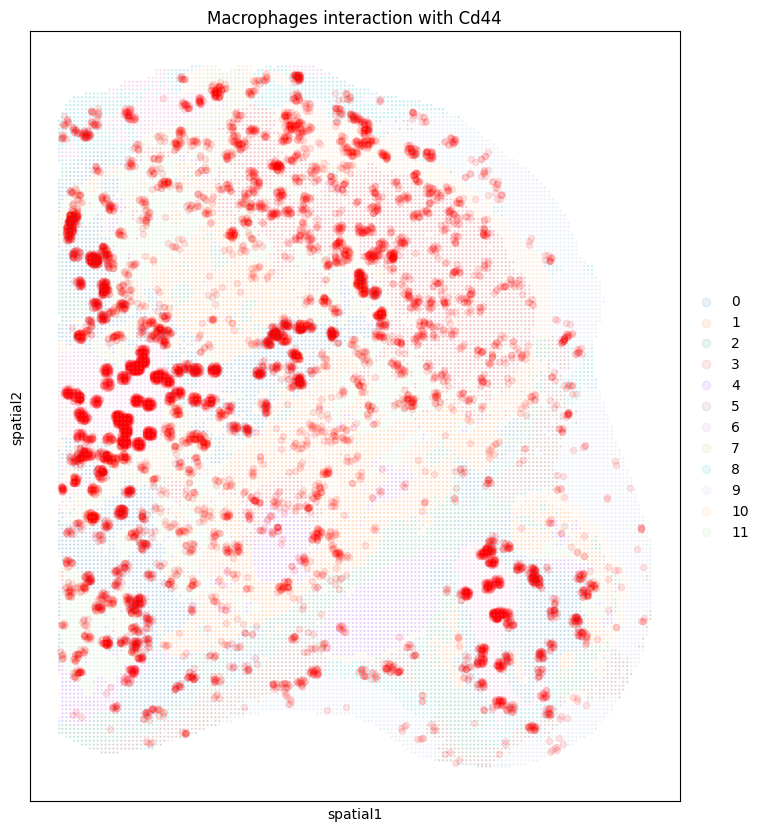

In [17]:
from sklearn.metrics import pairwise_distances
import random
r_dict = []
ligand = "Macrophages"
receptor = "Cd44"
annotation_ = annotation[annotation.obs["marker"] == "2-1"]
ligand_coord = annotation_[annotation_[:, receptor].X > 3].obsm["spatial"]
receptor_coord = annotation_[annotation_.obs["annotations"] == ligand].obsm["spatial"]
receptor_coord = receptor_coord[random.sample(range(len(receptor_coord)), 1000)]

distances = pairwise_distances(ligand_coord, receptor_coord)
close = distances < 120
for i in tqdm(range(close.shape[1])):
    r_dict = r_dict + ligand_coord[close[:, i]].tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.array(r_dict)[:, 0]
y = np.array(r_dict)[:, 1]
plt.scatter(x, y, s=20, alpha=0.1, color="Red")
sq.pl.spatial_scatter(fdata[fdata.obs["marker"] == "2-1"], color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax, alpha=0.1)
ax.set_title(f"{ligand} interaction with {receptor}")
plt.show()

In [ ]:
import pandas as pd
c_df = macro_data.obs[["cluster", "m_type"]].groupby("cluster").value_counts().unstack()
r_df = pd.concat([c_df.loc[[2,4,7,11]].sum(), c_df.loc[[0,1,3,5,6,8,9,10]].sum()], axis=1)
r_df.columns = ["hypoxia niche", "others"]

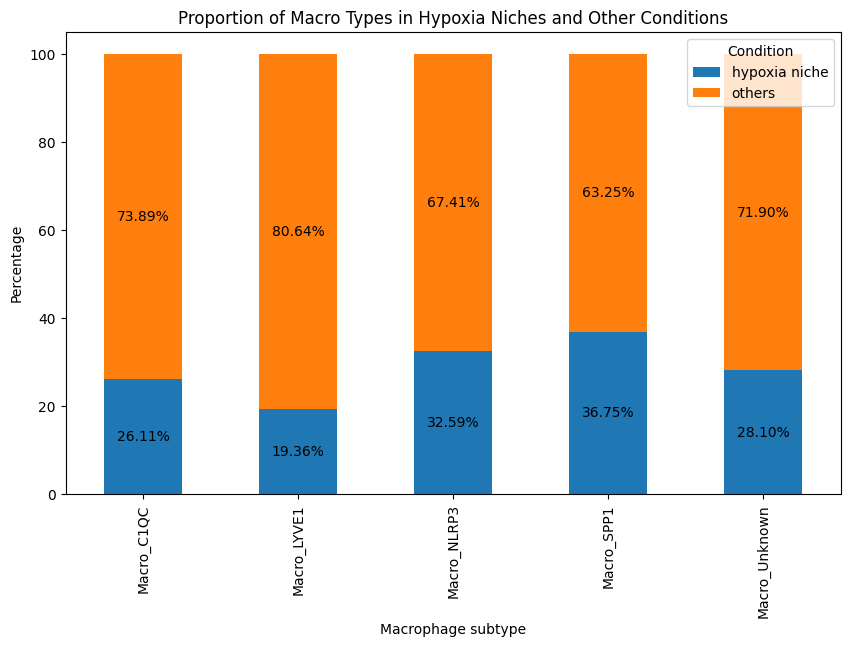

In [12]:
# Calculate the percentage
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

# Plot the data
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Macrophage subtype')
ax.set_title('Proportion of Macro Types in Hypoxia Niches and Other Conditions')
ax.legend(title='Condition')

# Add percentage labels on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

### Macrophage与T互作分布

In [61]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
for cluster in tqdm(np.unique(annotation_.obs["cluster"])):
        annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
        t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(annotation__.obs["annotations"] == "Macrophages")[0]
        coords = annotation__.obsm["spatial"]

        distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
        interactions = np.sum(distances < 30)
        r_dict[cluster] = interactions / len(t_cell_idx) / len(m_cell_idx)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:19<00:00,  1.66s/it]


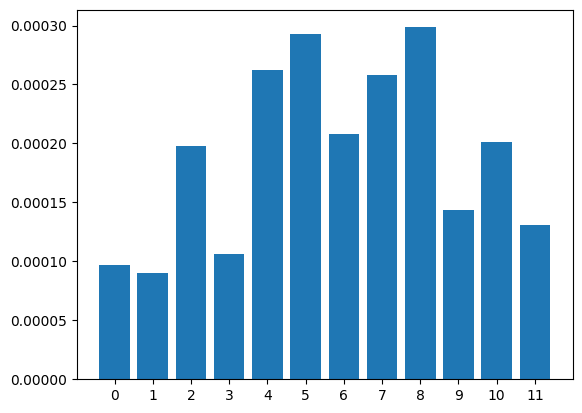

In [83]:
r_df = pd.DataFrame(r_dict, index=["frequency"]).T
r_df.index = r_df.index.astype(int)
r_df.sort_values(by="frequency", inplace=True)
plt.bar(x=r_df.index, height=r_df.frequency)
plt.xticks(range(0, 12))
plt.show()

In [13]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
for cluster in tqdm(np.unique(annotation_.obs["cluster"])):
    r_dict[cluster] = {}
    for m_type in np.unique(macro_data.obs["m_type"]):
        annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
        t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == cluster].obs["m_type"] == m_type)[0]
        t_coords = annotation__.obsm["spatial"]
        m_coords = macro_data.obsm["spatial"]

        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        interactions = np.sum(distances < 30)
        r_dict[cluster][m_type] = interactions / len(t_cell_idx) / len(m_cell_idx)

100%|██████████| 12/12 [00:24<00:00,  2.04s/it]


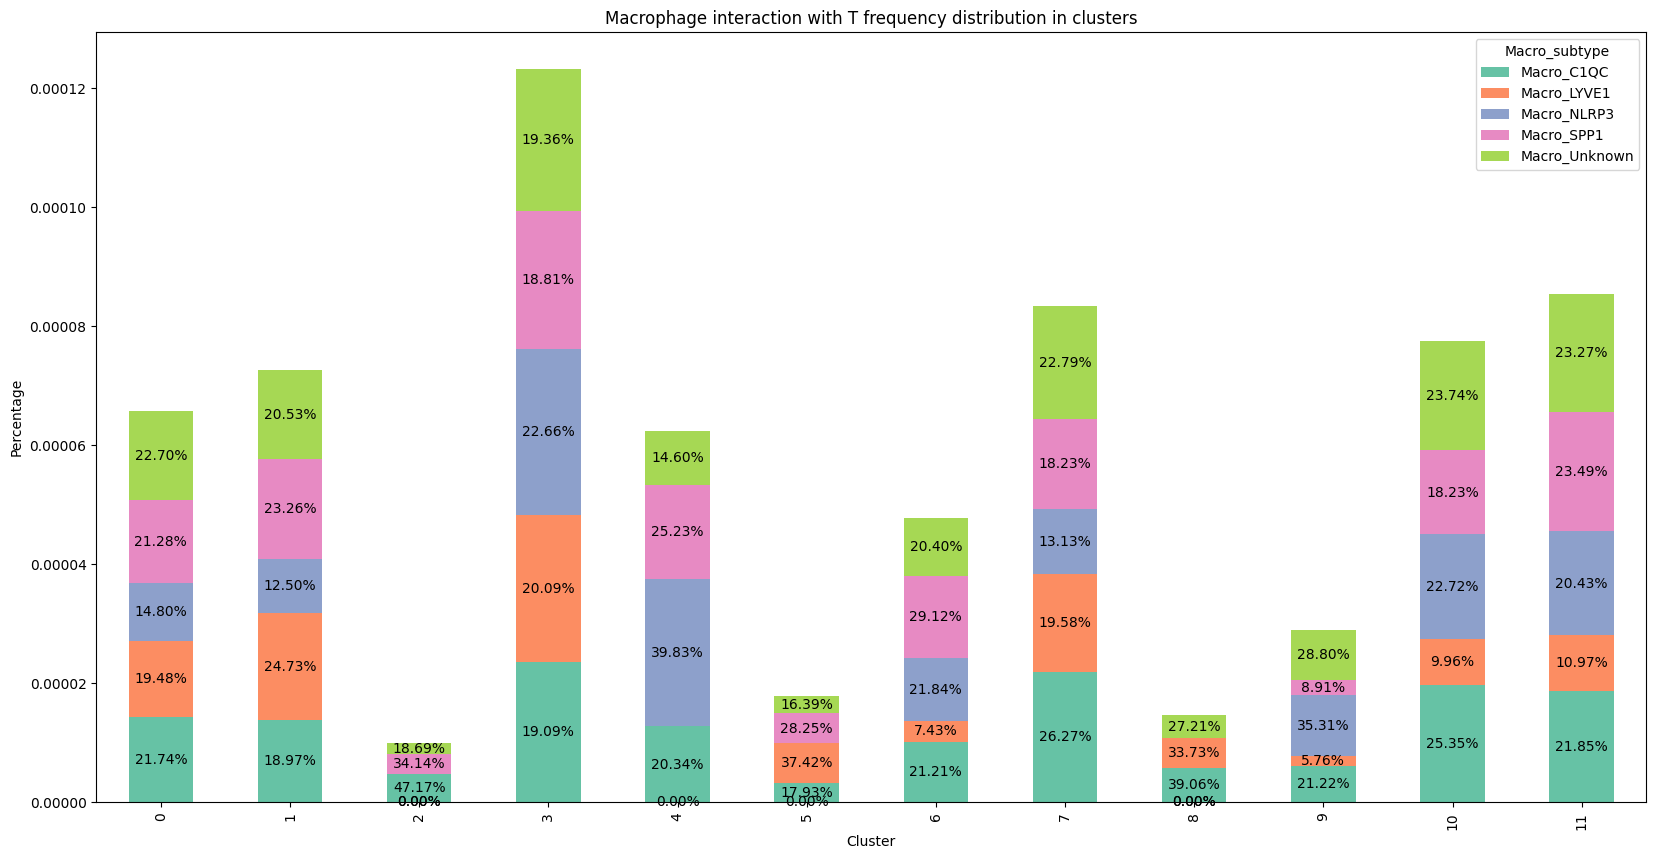

In [18]:
r_df = pd.DataFrame(r_dict, columns=range(0, 12)).T
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(len(r_df.columns))]

# Plot the data
#ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
ax = r_df.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors)

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster')
ax.set_title('Macrophage interaction with T frequency distribution in clusters')
ax.legend(title='Macro_subtype')

# Add percentage labels on top of the bars
cnt = 0
ep = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    cnt += 1
    ax.annotate(f'{df_percentage.iloc[int(x+0.3), ep]:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')
    if cnt == 12:
        cnt = 0
        ep += 1
plt.show()

In [99]:
r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
for cluster in tqdm(np.unique(annotation_.obs["cluster"])):
    r_dict[cluster] = {}
    for m_type in np.unique(macro_data.obs["m_type"]):
        annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
        t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == cluster].obs["m_type"] == m_type)[0]
        t_coords = annotation__.obsm["spatial"]
        m_coords = macro_data.obsm["spatial"]

        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        close = distances < 30
        for i in range(close.shape[1]):
            try:
                r_dict[cluster][m_type] = np.append(r_dict[cluster][m_type], np.array(t_coords[t_cell_idx][close[:, i]]), axis=0)
            except:
                r_dict[cluster][m_type] = np.array(t_coords[t_cell_idx][close[:, i]])

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [01:00<00:00,  5.01s/it]


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


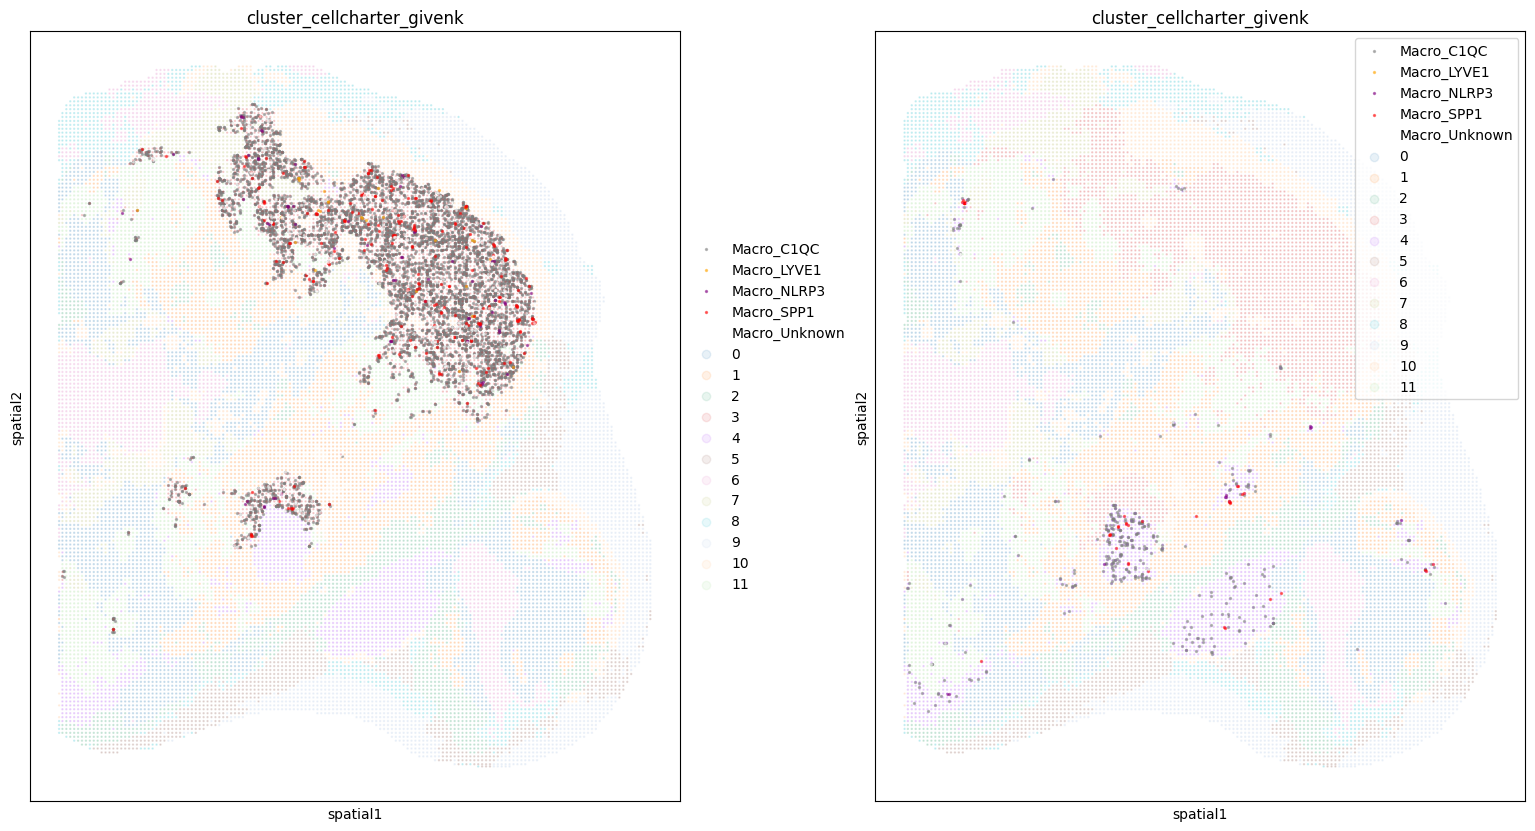

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
color_map = {
    'Macro_Unknown': 'White',
    'Macro_LYVE1': 'Orange',
    'Macro_SPP1': 'Red',
    'Macro_NLRP3': 'Purple',
    'Macro_C1QC': 'Grey'
}
for m_type, coords in r_dict[3.0].items():
    x = coords[:, 0]
    y = coords[:, 1]
    ax[0].scatter(x, y, s=2, alpha=0.5, color=color_map[m_type], label=m_type)
for m_type, coords in r_dict[4.0].items():
    x = coords[:, 0]
    y = coords[:, 1]
    ax[1].scatter(x, y, s=2, alpha=0.5, color=color_map[m_type], label=m_type)
sq.pl.spatial_scatter(fdata_, color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax[0], alpha=0.1)
sq.pl.spatial_scatter(fdata_, color="cluster_cellcharter_givenk", size=2, shape=None, library_id="spatial", ax=ax[1], alpha=0.1)
plt.legend()
plt.show()

### Cluster3作为焦点

In [9]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import pairwise_distances

r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
annotation__ = annotation_[annotation_.obs["cluster"] == 3.0]
t_coords = annotation__.obsm["spatial"]
m_coords = macro_data[macro_data.obs["cluster"] == 3.0].obsm["spatial"]
for t_type in np.unique(t_types):
    t_cell_idx = np.where(annotation__.obs["annotations"] == t_type)[0]
    r_dict[t_type] = {}
    for m_type in np.unique(macro_data.obs["m_type"]):
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == 3.0].obs["m_type"] == m_type)[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[t_type][m_type] = 0
            continue
        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        interactions = np.sum(distances < 30)
        r_dict[t_type][m_type] = interactions / len(t_cell_idx) / len(m_cell_idx)

In [10]:
import pandas as pd
pd.DataFrame(r_dict)

,Unknown T,effector T,exhausted T,memory T,stem-like T
Macro_SPP1+,0.000102,0.000119,0.000112,0.000115,0.000105
Macro_Unknown,0.000106,0.000106,0.000109,0.000104,0.000103


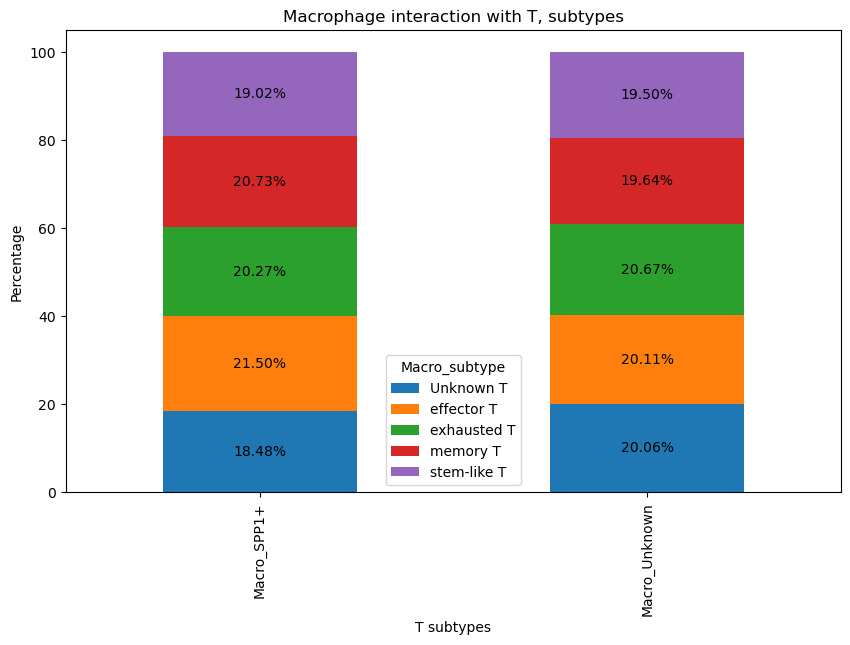

In [14]:
import matplotlib.pyplot as plt

r_df = pd.DataFrame(r_dict)
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

# Plot the data
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
#ax = r_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('T subtypes')
ax.set_title('Macrophage interaction with T, subtypes')
ax.legend(title='Macro_subtype')

# Add percentage labels on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()

### Exhaust score between interaction T with macrophage

We randomly select bins with / without interaction of T and macrophage, and compare exhaustion score between them.

In [11]:
import random

In [12]:
# random select 1000 bins
selected_index = random.sample(annotation_.obs_names.tolist(), 200)
random_data = annotation_[selected_index]

In [100]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import pairwise_distances

r_dict = {}
t_types = np.unique(annotation_.obs["annotations"][annotation_.obs["annotations"].str.endswith("T")])
cluster = 3.0
for m_type in tqdm(np.unique(macro_data.obs["m_type"])):
    annotation__ = annotation_[annotation_.obs["cluster"] == cluster]
    t_cell_idx = np.where(annotation__.obs["annotations"].str.endswith("T"))[0]
    m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == cluster].obs["m_type"] == m_type)[0]
    t_coords = annotation__.obsm["spatial"]
    m_coords = macro_data.obsm["spatial"]

    distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
    close = distances < 30
    for i in range(close.shape[1]):
        try:
            r_dict[m_type] = np.append(r_dict[m_type], np.array(annotation__[t_cell_idx].obs_names[close[:, i]]), axis=0)
        except:
            r_dict[m_type] = np.array(annotation__[t_cell_idx].obs_names[close[:, i]])

100%|██████████| 2/2 [01:27<00:00, 43.85s/it]


In [85]:
import scanpy as sc

exhaust_genes = ["Lag3", "Pdcd1", "Tigit", "Ctla4", 'Tox','Tnfrsf9','Tnfrsf18',  'Cxcr6', 'Cxcl13']
# exhaust_genes = ['Cd8a', 'Cd8b1', 'Lag3', 'Pdcd1', 'Tigit']
# exhaust_genes = ['Cd8a', 'Cd8b1', 'Pdcd1', 'Tnfrsf9']
sc.tl.score_genes(fdata, gene_list=exhaust_genes, score_name="score")

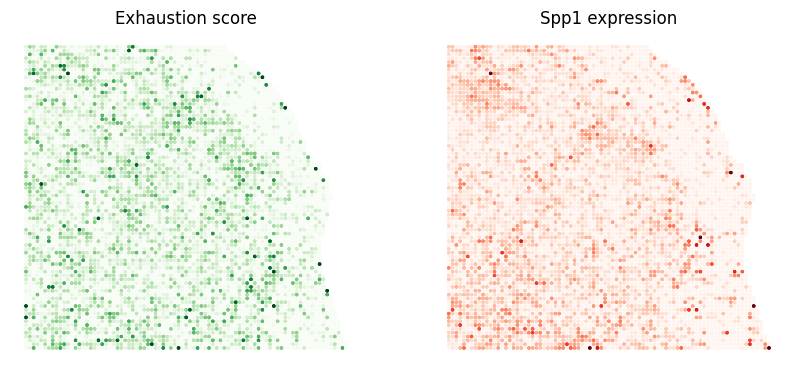

In [17]:
# import squidpy as sq
# import seaborn as sns
# import matplotlib.pyplot as plt

# fdata_ = fdata[fdata.obs.marker == '2-1']

# region = [[6000, 15000], [2000, 10000]]
# plot_data = fdata_[(fdata_.obsm['spatial'][:, 0] > region[0][0]) & (fdata_.obsm['spatial'][:, 0] <= region[0][1]) & (fdata_.obsm['spatial'][:, 1] > region[1][0]) & (fdata_.obsm['spatial'][:, 1] <= region[1][1])]
# _, ax = plt.subplots(1, 2, figsize=(10, 5))
# sq.pl.spatial_scatter(plot_data, color='score', size=10, shape=None, library_id="spatial", vmax=0.3, vmin=0, colorbar=False, cmap='Greens', ax=ax[0])
# sq.pl.spatial_scatter(plot_data, color='Spp1', size=10, shape=None, library_id="spatial", vmax=3, vmin=0.5, colorbar=False, cmap='Reds', ax=ax[1])
# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
# ax[0].set_ylabel('')
# ax[1].set_ylabel('')
# ax[0].set_title("Exhaustion score")
# ax[1].set_title("Spp1 expression")
# sns.despine(left=True, bottom=True)

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./plots/exhaustion_spp1_interaction_4.pdf', bbox_inches='tight', format='pdf')
# plt.show()

In [86]:
exh_scores = {}
from tqdm import tqdm
for m_type in tqdm(r_dict):
    interact_data = annotation_[r_dict[m_type]].copy()
    bin100_data = utils.extract_big_bin(fdata, interact_data)
    sc.tl.score_genes(bin100_data, gene_list=exhaust_genes, score_name="score")
    exh_scores[m_type] = bin100_data.obs["score"].tolist()
    # exh_scores[m_type] = np.array(bin100_data[:, exhaust_genes].X.mean(axis=1)).flatten()
    #exh_scores[m_type] = np.array(interact_data[:, exhaust_genes].X.mean(axis=1)).flatten()

  0%|          | 0/2 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
 50%|█████     | 1/2 [00:02<00:02,  2.24s/it]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


In [99]:
# 将 exh_scores 数据保存为 CSV 文件
import pandas as pd
import numpy as np

# 准备数据
data_dict = {}
for m_type, scores in exh_scores.items():
    data_dict[m_type] = scores

# 创建 DataFrame
# 注意：由于不同类型的巨噬细胞可能有不同数量的数据点，我们需要处理这种情况
max_length = max([len(scores) for scores in data_dict.values()])
for m_type, scores in data_dict.items():
    # 如果长度不足，用 NaN 填充
    if len(scores) < max_length:
        data_dict[m_type] = scores + [np.nan] * (max_length - len(scores))

# 创建 DataFrame 并保存为 CSV
df = pd.DataFrame(data_dict)
df.to_csv('./exhaustion_scores_by_macrophage_type.csv', index=False)
# print(f"已将耗竭评分数据保存至 './data/exhaustion_scores_by_macrophage_type.csv'")

/tmp/ipykernel_78816/2138359559.py:20: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(data=vec, ax=ax, palette=colors, linewidth=1, width=0.5, fliersize=0)


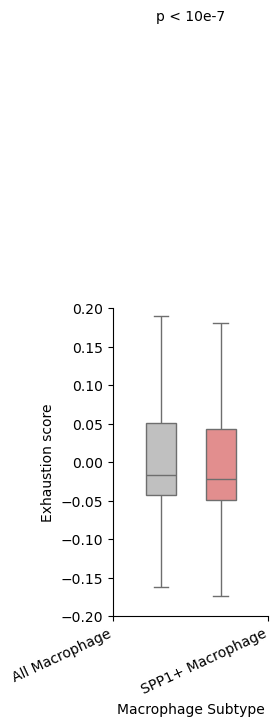

In [88]:
import scanpy as sc
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

sc.tl.score_genes(random_data, gene_list=exhaust_genes, score_name="score")
vec = [random_data.obs["score"].tolist()]
vec = [random_data[:, exhaust_genes].X.toarray().mean(axis=1).flatten()]
for value in exh_scores.values():
    vec.append(value)
vec = vec[1:]

fig, ax = plt.subplots(figsize=(2, 4))
# to violin plot
colors = ['silver', 'lightcoral', 'tan', 'cornflowerblue', 'grey']
colors_dark = ['#707070', '#EF5337', '#CA9510', '#5485DD', '#595959']
df = pd.DataFrame(vec).melt(ignore_index=False).dropna().reset_index(drop=False).drop(columns=["variable"]).rename(columns={"value": "exhaustion_score", "index": "macrophage_subtype"})

# sns.violinplot(data=vec, ax=ax, palette=colors, split=False, linewidth=1, alpha=1, width=0.5, bw_adjust=1.5)
sns.boxplot(data=vec, ax=ax, palette=colors, linewidth=1, width=0.5, fliersize=0)
# sns.stripplot(data=df, x="macrophage_subtype", y="exhaustion_score",
#               hue="macrophage_subtype", palette=colors_dark, edgecolor="none",
#               marker="o", size=3, legend=False, alpha=0.9, dodge=False)

p = f_oneway(vec[0], vec[1])

plt.vlines(x=0.1, ymin=0.52, ymax=0.55, color='black', linestyle='-', linewidth=1.5)
plt.vlines(x=0.9, ymin=0.52, ymax=0.55, color='black', linestyle='-', linewidth=1.5)
plt.text(x=0.5, y=0.57, s=f'p < 10e{np.log10(p[1]):.0f}', ha='center', va='bottom', color='black')
plt.hlines(y=0.55, xmin=0.1, xmax=0.9, color='black', linestyle='-', linewidth=1.5)

ax.set_xlabel("Macrophage Subtype")
ax.set_ylabel("Exhaustion score")

ax.set_xticks([-0.8, 1.8])
ax.set_xticklabels(["All Macrophage", "SPP1+ Macrophage"], rotation=25, ha='right')

spp1_a = f_oneway(vec[0], exh_scores["Macro_SPP1+"])

ax.set_ylim(-0.2, 0.2)
sns.despine(left=False, bottom=False)

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./plots/exhaustion_spp1_macrophage_interaction.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [103]:
test_data = macro_data.copy()
test_data.obs["Unknown"] = False
test_data.obs["Unknown"][test_data.obs["m_type"] == "Macro_Unknown"] = True
test_data.obs["Unknown"] = test_data.obs["Unknown"].astype("category")
sc.tl.rank_genes_groups(test_data, groupby="Unknown", method='t-test')

/tmp/ipykernel_68022/2014736182.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_data.obs["Unknown"][test_data.obs["m_type"] == "Macro_Unknown"] = True
/tmp/ipykernel_68022/2014736182.py:3: SettingWithCopyWarning: 
A value is trying 

In [130]:
f = open("genes.txt", 'w')
deg_list = pd.DataFrame(pd.DataFrame(test_data.uns["rank_genes_groups"]["names"][:50]).loc[:, "True"])
deg_list.to_csv("genes.txt", index=False)

### sgCd44 and Spp1+ Macrophage

In [23]:
cdata_ = utils.combine_guide_replicates(cdata_)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


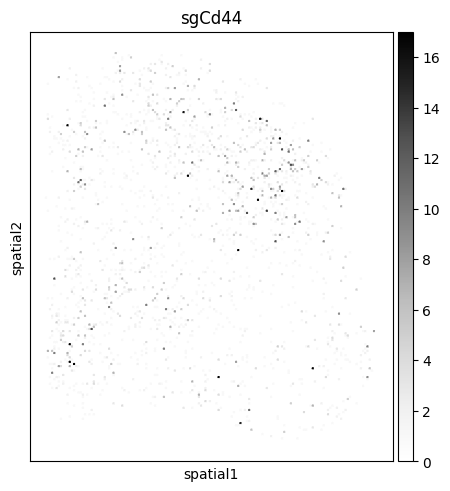

In [137]:
sq.pl.spatial_scatter(cdata_, color="sgCd44", shape=None, size=2, cmap="Greys", library_id="spatial", vmax=17)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


Text(0.5, 1.0, 'sgCd44 Perturbed T')

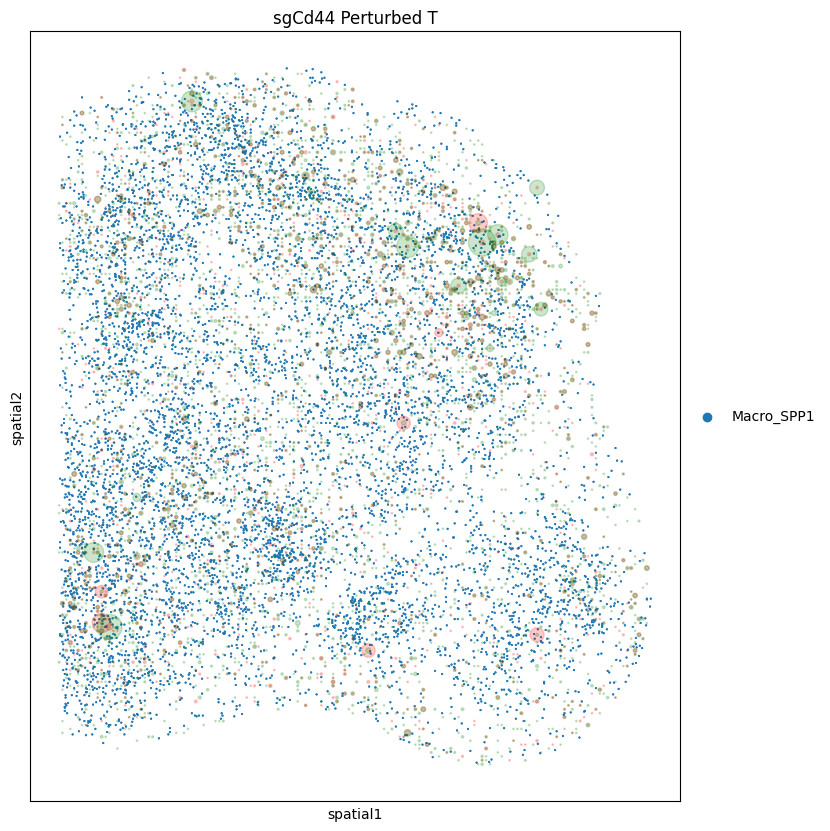

In [150]:
fig, ax=plt.subplots(1, 1, figsize=(10, 10))
sq.pl.spatial_scatter(macro_data[macro_data.obs["m_type"] == "Macro_SPP1"], color="m_type", shape=None, size=1, cmap="Greys", library_id="spatial", vmax=17, ax=ax)
utils.plot_dot(cdata_, gene_name="sgCd44", ax=ax, square=False, color="Red")
utils.plot_dot(cdata_, gene_name="sgNTC", ax=ax, square=False, color="Green")
ax.set_title("sgCd44 Perturbed T")
#ax.invert_yaxis()

In [13]:
annotation_guide_.obs["cluster"] = annotation_.obs["cluster"].tolist()

In [168]:
annotation_guide__[:, guide].X.toarray() > 2

array([], shape=(0, 1), dtype=bool)

In [21]:
# compared with sgNTC, Spp1+ Macro ~ sgCd44 interacted T cells showed less exhaustion
r_dict = {}
annotation__ = annotation_[annotation_.obs["cluster"] == 3.0]
annotation_guide__ = annotation_guide_[annotation_guide_.obs["cluster"] == 3.0]
t_coords = annotation_guide__.obsm["spatial"]
m_coords = macro_data[macro_data.obs["cluster"] == 3.0].obsm["spatial"]
for guide in tqdm(annotation_guide_.var_names):
    r_dict[guide] = {}
    t_cell_idx = np.where(annotation_guide__[:, guide].X.toarray() > 2)[0]
    for m_type in np.unique(macro_data.obs["m_type"]):
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == 3.0].obs["m_type"] == m_type)[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[guide][m_type] = 0
            continue
        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        interactions = np.sum(distances < 125)
        r_dict[guide][m_type] = interactions / len(m_cell_idx)

100%|██████████| 34/34 [00:11<00:00,  3.08it/s]


In [187]:
pd.DataFrame(r_dict)[["sgZc3h12a", "sgCd44", "sgNTC"]]

,sgZc3h12a,sgCd44,sgNTC
Macro_C1QC,0.034065,0.011115,0.019025
Macro_LYVE1,0.066667,0.033333,0.040000
Macro_NLRP3,0.037162,0.020270,0.027027
Macro_SPP1,0.024626,0.007916,0.009675
Macro_Unknown,0.027532,0.006391,0.012291


0.4943006356424563


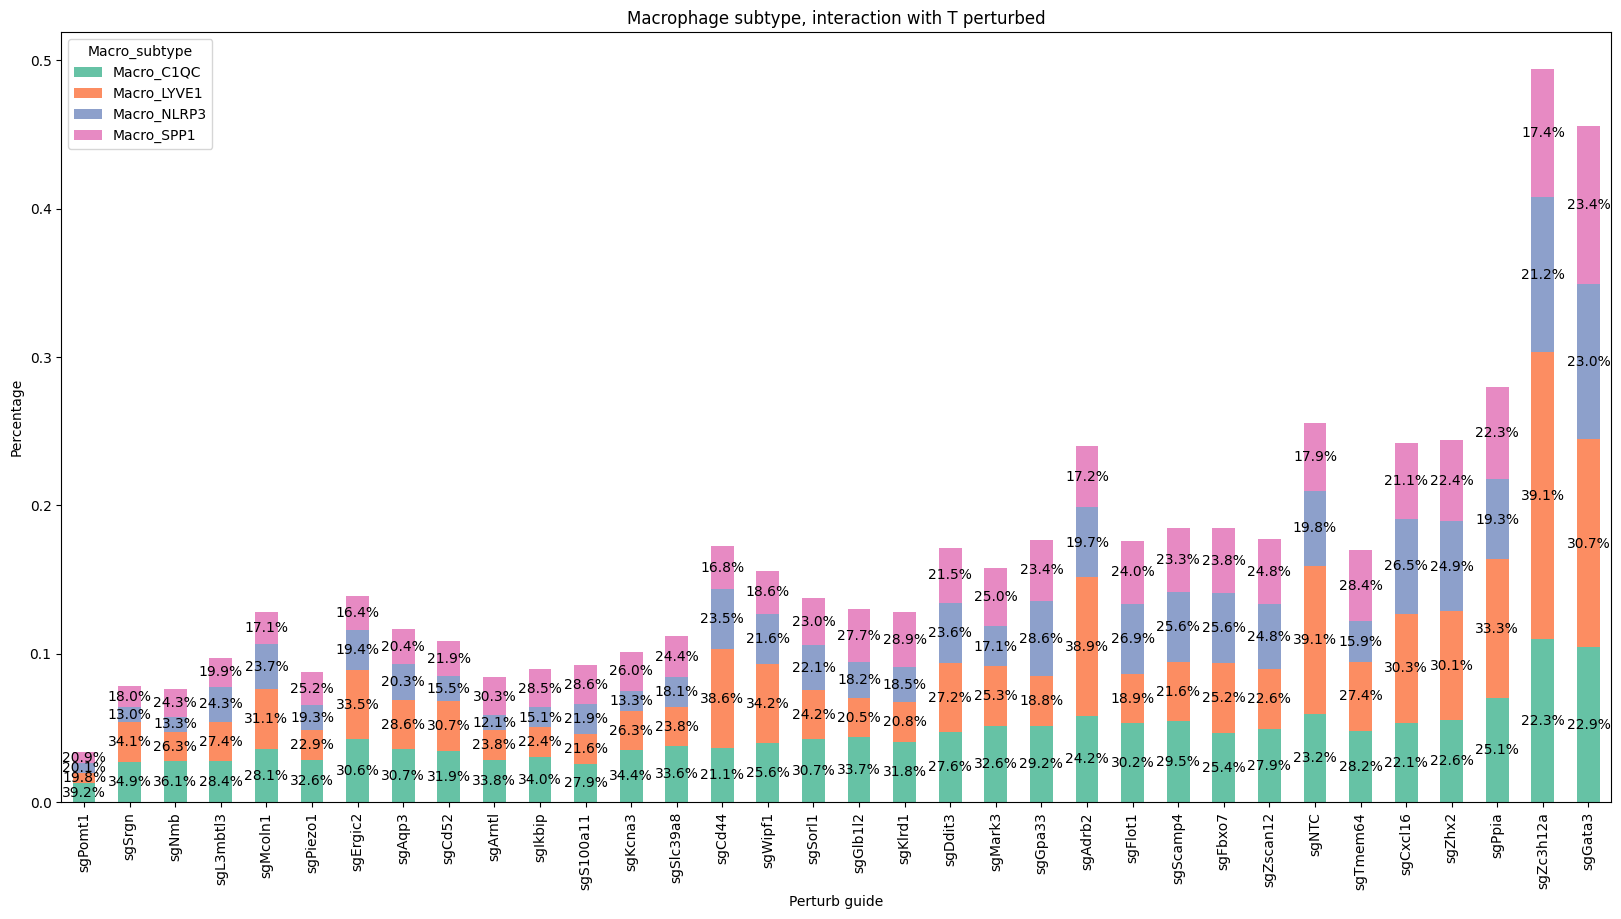

In [22]:
r_df = pd.DataFrame(r_dict).T
r_df = r_df.iloc[:, :-1]
r_df.sort_values(by="Macro_SPP1", ascending=True, inplace=True)
df_percentage = r_df.div(r_df.sum(axis=1), axis=0) * 100

cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(len(r_df.columns))]

# Plot the data
#ax = df_percentage.plot(kind='bar', stacked=True, figsize=(20, 10))
ax = r_df.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors)

# Set plot labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Perturb guide')
ax.set_title('Macrophage subtype, interaction with T perturbed')
ax.legend(title='Macro_subtype', loc='upper left')

max_ = r_df.sum(axis=1).max()
print(max_)

# Add percentage labels on top of the bars
cnt = 0
ep = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    cnt += 1
    ax.annotate(f'{df_percentage.iloc[int((x+0.3) // 1), ep]:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')
    if cnt == 34:
        ep += 1
        cnt = 0
plt.show()

### sgCd44 interaction with Spp1 Macrophage cause less exhaustion

In [63]:
r_dict = {}
annotation__ = annotation_[annotation_.obs["cluster"] == 3.0]
annotation_guide__ = annotation_guide_[annotation_guide_.obs["cluster"] == 3.0]
t_coords = annotation_guide__.obsm["spatial"]
m_coords = macro_data[macro_data.obs["cluster"] == 3.0].obsm["spatial"]
# annotation__ = annotation_.copy()
# annotation_guide__ = annotation_guide_.copy()
# t_coords = annotation_guide__.obsm["spatial"]
# m_coords = macro_data.obsm["spatial"]
for guide in tqdm(annotation_guide_.var_names):
    r_dict[guide] = {}
    t_cell_idx = np.where(annotation_guide__[:, guide].X.toarray() > 2)[0]
    if guide != "sgNTC" and guide != "sgCd44" and guide != "sgGata3": continue
    for m_type in np.unique(macro_data.obs["m_type"]):
        if m_type != "Macro_SPP1": continue
        m_cell_idx = np.where(macro_data[macro_data.obs["cluster"] == 3.0].obs["m_type"] == m_type)[0]
        if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
            r_dict[guide][m_type] = 0
            continue
        distances = pairwise_distances(t_coords[t_cell_idx], m_coords[m_cell_idx])
        close = distances < 35
        for i in range(close.shape[1]):
            try:
                r_dict[guide][m_type] = np.append(r_dict[guide][m_type], np.array(annotation_guide__[t_cell_idx].obs_names[close[:, i]]), axis=0)
            except:
                r_dict[guide][m_type] = np.array(annotation_guide__[t_cell_idx].obs_names[close[:, i]])

100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


In [64]:
exh_scores = {}
for guide in tqdm(annotation_guide_.var_names):
    if guide != "sgNTC" and guide != "sgCd44" and guide != "sgGata3": continue
    interact_data = annotation_guide_[r_dict[guide]["Macro_SPP1"]].copy()
    bin100_data = utils.extract_big_bin(fdata, interact_data)
    sc.tl.score_genes(bin100_data, gene_list=exhaust_genes, score_name="score")
    #exh_scores[guide] = bin100_data.obs["score"].tolist()
    exh_scores[guide] = np.array(bin100_data[:, exhaust_genes].X.mean(axis=1)).flatten()

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 36.25it/s]


In [42]:
exh_scores

{}

In [29]:
# random select 1000 bins
import random
selected_index = random.sample(annotation__.obs_names.tolist(), 20)
random_data = annotation__[selected_index]

sgCd44
0.17132572243137503
sgGata3
0.13922990960405576
sgNTC
0.1279387659404059


Text(1.5, 0.6467927041988064, 'p = 0.817')

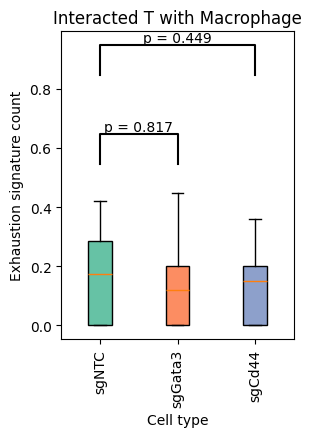

In [65]:
sc.tl.score_genes(random_data, gene_list=exhaust_genes, score_name="score")
vec = []

for key, value in exh_scores.items():
    if key not in ["sgNTC", "sgCd44", "sgGata3"]: continue
    else: print(key)
    print(np.mean(value))
    vec.append(value)

fig, ax = plt.subplots(figsize=(3,4))
box = ax.boxplot(vec, patch_artist=True, flierprops=dict(marker='.', markerfacecolor='w', markersize=1, linestyle='none'))

cmap = plt.get_cmap('Set2')
colors = [cmap(i) for i in range(4)]

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([i + 1 for i in range(3)])
ax.set_xticklabels(["sgNTC", "sgGata3", "sgCd44"], rotation=90)

ax.set_title("Interacted T with Macrophage")
ax.set_xlabel("Cell type")
ax.set_ylabel("Exhaustion signature count")

cd44_a = f_oneway(vec[0], vec[2])
gata3_a = f_oneway(vec[1], vec[2])

x1, x2, x3 = 1, 2, 3
h, col = 0.1, 'k'
max_ = np.max(vec[1])
y2, y3 = max_ + 0.1, max_ + 0.4
ax.plot([x1, x1, x2, x2], [y2, y2 + h, y2 + h, y2], lw=1.5, c=col)
ax.plot([x1, x1, x3, x3], [y3, y3 + h, y3 + h, y3], lw=1.5, c=col)
ax.text((x1 + x3) * .5, y3 + h, f"p = {cd44_a[1]:.3f}", ha='center', va='bottom', color=col)
ax.text((x1 + x2) * .5, y2 + h, f"p = {gata3_a[1]:.3f}", ha='center', va='bottom', color=col)

In [ ]:
pr_dict = {}
for marker in np.unique(annotation.obs["marker"]):
    r_dict[marker] = {}
    for cluster in tqdm(np.unique(annotation.obs["cluster"])):
        r_dict[marker][cluster] = {}
        for t_type in t_types:
            annotation_ = annotation[(annotation.obs["marker"] == marker) & (annotation.obs["cluster"] == cluster)]
            t_cell_idx = np.where(annotation_.obs["annotations"] == t_type)[0]
            m_cell_idx = np.where(annotation_.obs["annotations"] == "Macrophages")[0]
            if len(t_cell_idx) == 0 or len(m_cell_idx) == 0:
                r_dict[marker][cluster][t_type] = 0
                continue
            coords = annotation_.obsm["spatial"]
            distances = pairwise_distances(coords[t_cell_idx], coords[m_cell_idx])
            interactions = np.sum(distances < interaction_threshold)
            r_dict[marker][cluster][t_type] = interactions / len(t_cell_idx)